Inference seems to be redoing a lot of work every time I run it again. Couldn't we make it faster by reusing what was done previously somehow?

One way to achieve this above is to add learning on top of inference. Often, this can be done in a variety of ways that fall under the umbrella of amortized inference. We will explore a few options here.

First, let's set up a basic deterministic model and recall how to do learning via gradient descent in that setting, in Jax.

In [2]:
# Download and extract the MNIST dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-05-17 00:50:47--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-05-17 00:50:47--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.7’

MNIST.tar.gz.7          [             <=>    ]  33.20M  12.0MB/s    in 2.8s    

2024-05-17 00:50:51 (12.0 MB/s) - ‘MNIST.tar.gz.7’ saved [34813078]

x MNIST/
x MNIST/raw/
x MNIST/raw/train-labels-idx1-ubyte
x MNIST/raw/t10k-labels-idx1-ubyte.gz
x MNIST/raw/t10k-labels-idx1-ubyte
x MNIST/raw/t10k-images-idx3-ubyte.gz
x MNIST/raw/train-images-idx3-ubyte
x MNIST/raw/train-labels-idx1-ubyte.gz
x MNIST/raw/t10k-images-idx3-ubyte
x MNIST/raw/train-images-idx3-ubyte.gz
x MNIST/processed/
x MNIST/processed/training.pt
x MNIST/proces

In [1]:
### Simple model and training loop for the MNIST dataset
# Taken from the JAX quickstart guide
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random


## Hyperparameters
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.key(0))

## Auto-batching predictions
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, image):
  # per-example predictions
  activations = image
  for w, b in params[:-1]:
    outputs = jnp.dot(w, activations) + b
    activations = relu(outputs)
  
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  return logits - logsumexp(logits)

# This works on single examples. Let's upgrade it to handle batches using `vmap`
batched_predict = vmap(predict, in_axes=(None, 0))

## Utility and loss functions
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

## Data Loading with PyTorch
import numpy as np
from jax.tree_util import tree_map
from torch.utils import data
from torchvision.datasets import MNIST
from torchvision import transforms

def numpy_collate(batch):
  return tree_map(np.asarray, data.default_collate(batch))

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

class FlattenAndCast(object):
  def __call__(self, pic):
    return np.ravel(np.array(pic, dtype=jnp.float32))

# Define our dataset, using torch datasets
mnist_dataset = MNIST('./', download=False,
                    transform=FlattenAndCast(), train=True)
training_generator = NumpyLoader(mnist_dataset, batch_size=batch_size, num_workers=0)

# Get the full train dataset (for checking accuracy while training)
train_images = np.array(mnist_dataset.train_data).reshape(len(mnist_dataset.train_data), -1)
train_labels = one_hot(np.array(mnist_dataset.train_labels), n_targets)

# Get full test dataset
mnist_dataset_test = MNIST('./', download=False,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]), train=False)
test_images = jnp.array(mnist_dataset_test.test_data.numpy().reshape(len(mnist_dataset_test.test_data), -1), dtype=jnp.float32)
test_labels = one_hot(np.array(mnist_dataset_test.test_labels), n_targets)

/Users/matuot/repos/genjax-docs/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/matuot/repos/genjax-docs/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/Users/matuot/repos/genjax-docs/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/matuot/repos/genjax-docs/.venv/lib/python3.11/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
## Training loop
import time

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in training_generator:
    y = one_hot(y, n_targets)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 2.04 sec
Training set accuracy 0.9157500267028809
Test set accuracy 0.9196999669075012
Epoch 1 in 1.73 sec
Training set accuracy 0.9371166825294495
Test set accuracy 0.9383999705314636
Epoch 2 in 1.81 sec
Training set accuracy 0.9492000341415405
Test set accuracy 0.946899950504303
Epoch 3 in 1.70 sec
Training set accuracy 0.9569000005722046
Test set accuracy 0.9532999992370605
Epoch 4 in 1.76 sec
Training set accuracy 0.9630833268165588
Test set accuracy 0.9575999975204468
Epoch 5 in 1.74 sec
Training set accuracy 0.9673666954040527
Test set accuracy 0.9615999460220337
Epoch 6 in 1.69 sec
Training set accuracy 0.9708666801452637
Test set accuracy 0.9648000001907349
Epoch 7 in 1.79 sec
Training set accuracy 0.973716676235199
Test set accuracy 0.9668999910354614


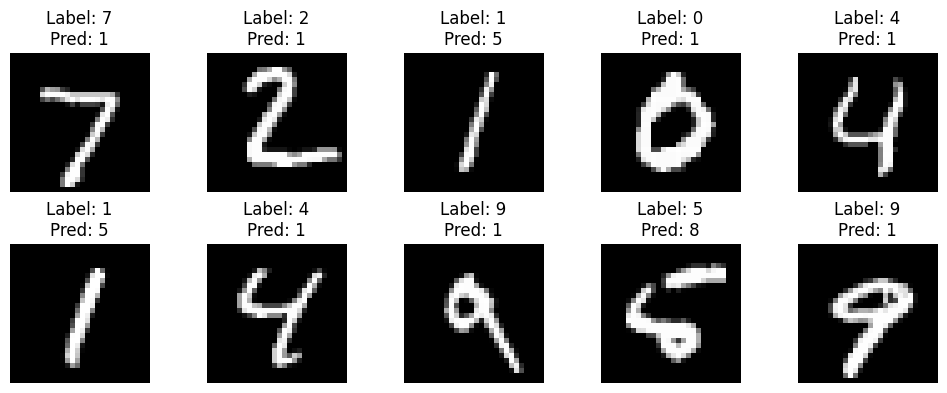

In [2]:
# Let's visualize some of the images and their predictions
import matplotlib.pyplot as plt

def plot_images_with_labels_and_pred(images, labels, preds):
    _, axs = plt.subplots(2, 5, figsize=(10, 4))
    axs = axs.ravel()
    for i in range(10):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title("Label: {}\nPred: {}".format(labels[i], preds[i]))
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()
    
# Plot the first 10 test images
plot_images_with_labels_and_pred(test_images[:10], np.argmax(test_labels[:10], axis=1), np.argmax(batched_predict(params, test_images[:10]), axis=1))

We will adapt this neural network to see it as a generative function in Genjax.
To do so, we will define a noisy renderer from which the images from MNIST dataset will be observations.
The goal of the inference task for the model is to infer what the label is (i.e. which digit) for a given observation (ofi.e. image), and we will tune the parameters generative function to do a better job on average on this dataset.

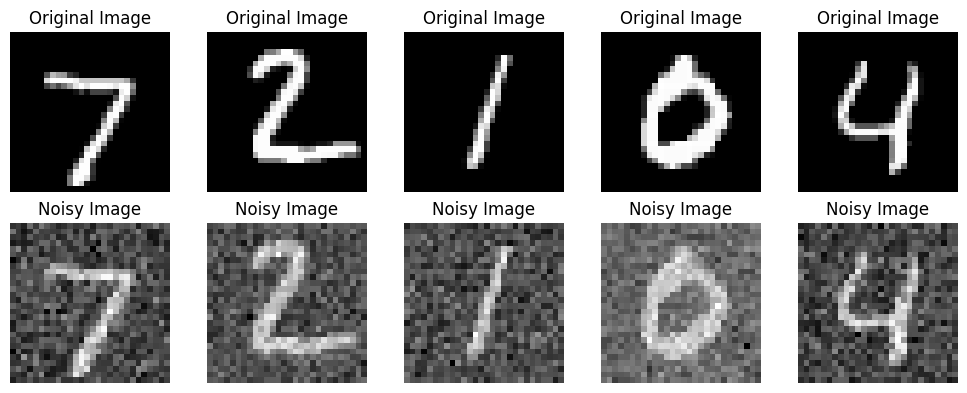

In [3]:
from genjax import gen, normal, vmap_combinator
from jax import jit

# First, we define a noisy renderering function
# This is an extremely simple model that adds Gaussian noise to each pixel
@gen
def pixel_renderer(pixel):
    noisy_pixel = normal(pixel,50.0) @ "noisy_pixel"
    return noisy_pixel

image_renderer = jit(vmap_combinator(in_axes=(0,))(vmap_combinator(in_axes=(0,))(pixel_renderer)).simulate)

# Let's generate some noisy images and plot them
key = random.PRNGKey(0)
keys = random.split(key, 5)

def plot_images_and_noisy(images,noisy_images):
    n = len(images)
    _, axs = plt.subplots(2, n, figsize=(10, 4))
    axs = axs.ravel()
    for i in range(n):
        axs[i].imshow(images[i].reshape(28, 28), cmap='gray')
        axs[i].set_title("Original Image")
        axs[i].axis('off')
    for i in range(n):
        axs[i+n].imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        axs[i+n].set_title("Noisy Image")
        axs[i+n].axis('off')
    plt.tight_layout()
    plt.show()
 
images = test_images[:5]
noisy_images = list(map(lambda x,y: image_renderer(y, (x.reshape(28, 28),)).get_retval(),images, keys))    
noisy_images
plot_images_and_noisy(images, noisy_images)

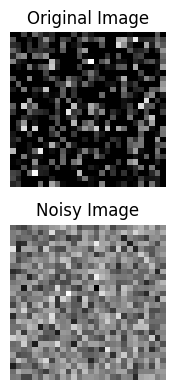

In [4]:
# Next, we define a simple generative model that takes in a latent vector of parameters and generates an image. 
# We will rewrite a more efficient batched version later.

from genjax import categorical
from jax import nn

# Hyperparameters
num_digits = 10
layer_sizes = [10, 512, 512, 784]
# Initialize the network parameters
key = random.PRNGKey(0)
params = init_network_params(layer_sizes, key)
noise_params = [random.normal(key, (784,)) for key in random.split(key, 784)]

#Utility functions
def create_one_hot_vector(integer, size):
    return nn.one_hot(jnp.array(integer), size, axis=-1)[0]

# Keeping the image as a 1D array to match the MNIST dataset    
oneD_noisy_renderer = vmap_combinator(in_axes=(0,))(pixel_renderer)

#TODO: Adapt to use noise_params for variance of the Gaussian noise
@gen
def model(params, noise_params):
    prior = jnp.ones(num_digits) / num_digits
    digit = categorical(prior) @ "digit" 
    activations = create_one_hot_vector((digit,), num_digits)
    
    for w, b in params:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    noisy_image = oneD_noisy_renderer((activations,)) @ "noisy_image"
    return noisy_image

jitted_model = jit(model.simulate)
trace = jitted_model(key, (params,noise_params))
noisy_image = trace.get_retval()

# Version to print the non-noisy image
@gen
def image_from_digit(params):
    prior = jnp.ones(num_digits) / num_digits
    digit = categorical(prior) @ "digit" 
    activations = create_one_hot_vector((digit,), num_digits)
    
    for w, b in params:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    return activations

#We can test the untrained generative model by sampling from it
jitted_image_from_digit = jit(image_from_digit.simulate)
tr = jitted_image_from_digit(key, (params,))
image = tr.get_retval()

plot_images_and_noisy(jnp.expand_dims(image, axis=0), jnp.expand_dims(noisy_image, axis=0))

In [2]:
# We can do inference on the untrained model for a fixed image by using importance sampling

# Create an observation by creating a partial choice map with a fixed image
from genjax import ChoiceMapBuilder as C
from genjax import Target, smc
chm = C["noisy_image"].set(test_images[5])

# Run importance sampling, once
arg = (params, noise_params)
key = random.PRNGKey(0)
tr, _ = jit(model.importance)(key, chm, arg)
print("infered digit:", tr.get_sample()["digit"])

# Util to show the posterior on digits
def plot_posterior(digits, weights):
    n = len(digits)
    d = dict()
    for i in range(n):
        element = digits[i]
        if element in d:
            d[element] += weights[i]
        else:
            d[element] = weights[i]
    sorted_d = {key: d[key] for key in sorted(d.keys())}
    return sorted_d

# Run importance sampling, multiple times
# TODO: is currently ignoring the weight from IS, need normalization
sub_keys = random.split(key, 1000)
tr = jit(vmap(model.simulate, in_axes=(0, None)))(sub_keys, arg)
digits = tr.get_sample()["digit"]
weights = tr.get_score()
print("Approximate posterior:", plot_posterior(np.array(digits), weights))

#TODO: alternative way to run importance sampling
# target = Target(model, (arg,), chm)
# alg = smc.ImportanceK(target, k_particles=500)
# sub_keys = random.split(key, 50)
# posterior_samples = jit(vmap(alg.simulate, in_axes=(0, None)))(
#     sub_keys, (target,)
# ).get_retval()

NameError: name 'test_images' is not defined

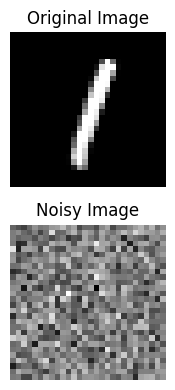

ValueError: too many values to unpack (expected 2)

In [76]:
import genjax
from genjax._src.adev.core import (
    expectation,
)

from genjax._src.core.typing import (
    PRNGKey,
    Tuple,
)

# Next, we can train the model by improving the parameters in a variety of ways.
# One way is to define a loss function that measures the difference between the generated image and the observed image.

# A simple loss function on images is the mean squared error
# def loss(image_1, image_2):
#     return jnp.mean((image_1 - image_2) ** 2)

# The total loss function we want to minimize is given by
# E_{img ~ Uniform(MNIST)} E_{img ~ model} [loss(img, img')]
# i.e. we train the parameters to minimize the expected loss between the generated images and the observed images, averaged over all images in the MNIST dataset.
# This is an instance of amortized inference, where we learn a generative model that can generate images that are close to the observed images. 
# Reverting the process by observing an image, we can infer the posterior distribution on digits that could generate the image under the model.

# To do so, we will need to differentiate through the model and the loss function. We will use ADEV to do this. 
# We have to slightly rewrite the model to be compatible with ADEV.

num_digits = 10
layer_sizes = [10, 512, 512, 784]
params = init_network_params(layer_sizes, key)

@gen
def diff_pixel_renderer(pixel):
    noisy_pixel = genjax.vi.normal_reparam(pixel,50.0) @ "noisy_pixel" #Note that it's the only change!
    return noisy_pixel

diff_oneD_noisy_renderer = vmap_combinator(in_axes=(0,))(diff_pixel_renderer)

@gen
def diff_model(params):
    prior = jnp.ones(num_digits) / num_digits
    digit = categorical(prior) @ "digit" 
    activations = create_one_hot_vector((digit,), num_digits)
    
    for w, b in params:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    noisy_image = diff_oneD_noisy_renderer((activations,)) @ "noisy_image"
    return noisy_image

# Testing
jitted_diff_model = jit(diff_model.simulate)
params = init_network_params(layer_sizes, key)
trace = jitted_diff_model(key, (params,))
noisy_image = trace.get_sample()["noisy_image",...,"noisy_pixel"]

plot_images_and_noisy(jnp.expand_dims(image, axis=0), jnp.expand_dims(noisy_image, axis=0))

# Gradient estimate function
def grad_estimate(
        key: PRNGKey,
        args: Tuple,
    ) -> Tuple:
        @expectation
        def loss(*target_args):
            first_args = target_args[:-1]
            image = target_args[-1]
            #first_args = tuple(first_args)
            noisy_image = diff_model.simulate(key, (first_args,)).get_retval()
            return jnp.mean((noisy_image - image) ** 2)
        return loss.grad_estimate(key, args)
        # def loss(*target_args):
        #     noisy_image = diff_model.simulate(key, *target_args).get_retval()
        #     return jnp.mean((noisy_image - test_images[5]) ** 2)
        # return loss.estimate(key, args)

#Update the model parameters
@jit
def update(params, params_grad):
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, params_grad)]

# Training the model
n_trials = 1000
step_size = 0.01
key = random.PRNGKey(0)
# jitted_loss = jit(grad_estimate)
jitted_loss = grad_estimate
test_image = jnp.ones((784,))
params = (init_network_params(layer_sizes, key), test_image)
# params = (init_network_params(layer_sizes, key),)
params_grad = jitted_loss(key, params)
# for _ in range(n_trials):
#     #TODO: fix the bug and need to provide minibatch of images
#     key, subkey = random.split(key)
#     (params_grad,) = jitted_loss(subkey, (params,))
#     params =  update(params, params_grad)


In [ ]:
# Can try a few options by doing fake hand-coded gradient descent, then GD, then ADEV, then maybe RWS etc.
#TODO: answer question "How to batch my model?"

In [50]:

#TODO: scratch code
import pytest

@genjax.gen
def model(v):
    mu = genjax.normal(0.0, 10.0) @ "mu"
    _ = genjax.normal(mu, 0.1) @ "v"

@genjax.marginal
@genjax.gen
def guide(target):
    (v,) = target.args
    _ = genjax.vi.normal_reparam(v, 0.1) @ "mu"

key = random.PRNGKey(314159)
elbo_grad = genjax.vi.ELBO(
    guide, lambda v: genjax.Target(model, (v,), C["v"].set(3.0))
)
v = 0.1
jitted = jit(elbo_grad)
for _ in range(200):
    (v_grad,) = jitted(key, (v,))
    v -= 1e-3 * v_grad
assert v == pytest.approx(3.0, 5e-2)

In [19]:
#TODO: scratch code
import genjax
import jax
import jax.numpy as jnp
from genjax.adev import expectation, normal_reparam

@expectation
def model(y):
    x = jax.vmap(normal_reparam, in_axes=(0, None))(y, 3.0)
    return jnp.sum(x) ** 2

key = jax.random.PRNGKey(314159)
model.grad_estimate(key, (jnp.ones(10, dtype=float), ))

(Array([13.506142, 13.506142, 13.506142, 13.506142, 13.506142, 13.506142,
        13.506142, 13.506142, 13.506142, 13.506142], dtype=float32),)